TODO:
Skrive små afsnit!
- Husk ord som:
- uni-direction/bi-directional
- connected graph

Breath-first-search implimentation

In [222]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

import networkx as nx
#import nxviz as nv

#import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from congress import Congress
import pickle

import community

# ------------------------------------------

#data_set = pd.read_csv("friends.csv", index_col=0)

pkl_file = open('essentials.pkl', 'rb')
essentials = pickle.load(pkl_file)

congress = Congress(essentials["congress_key"]) # use your own congress key

pkl_file.close()

house = congress.members.filter("house")
house_members = house[0]['members']

df_house = pd.DataFrame(house_members)

reps = df_house.twitter_account

reps.dropna(inplace=True)

# for metadata:

repulicans = [i for i in list(df_house[df_house.party == "R"]["twitter_account"]) if i] # remove None_type hack -> men none types er vel indies
democrats = [i for i in list(df_house[df_house.party == "D"]["twitter_account"]) if i] # remove None_type hack


In [223]:
sum(df_house.twitter_account == "hurdonthehill") # HE IS THERE. Men det er noget med små og store bogstaver....

1

In [224]:
set(df_house.party) # hvor kommer ingen indies!

{'D', 'R'}

In [225]:
pkl_file = open('edges_RepMcGovern.pkl', 'rb')
edges = pickle.load(pkl_file)
pkl_file.close()

In [226]:
G = nx.Graph()
G.add_edges_from(edges) # Indies må komme herfra! Der må være edges som du ikke har nodes på....
G.add_nodes_from(repulicans, party = "R", party_int = 0)
G.add_nodes_from(democrats, party = "D", party_int = 1)

no_party = []

for i, p in list(G.nodes(data=True)):
    if len(p) == 0:
        no_party.append(i)
        
G.remove_nodes_from(no_party) # det er nok det her der burde ske.. men så skal low_degree ind efter...

#G.add_nodes_from(no_party, party = "non", party_int = 2)


low_degree = []

for i in list(G.degree()):
    if i[1] < 1: # a bit high..
        low_degree.append(i[0])
        
G.remove_nodes_from(low_degree)


R_nodes = [n for n, p in list(G.nodes(data=True)) if p['party'] == 'R']
D_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'D']
#N_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'non']

# kunne også være et andet ste, men nu er du jo igang her..
voting_with_party = dict(df_house[["twitter_account","votes_with_party_pct"]].dropna().to_dict(orient='split')["data"])
nx.set_node_attributes(G, voting_with_party, "voting_with_party_pct")

In [227]:
#N_nodes # så skal vi finde ud af hvor de hører til..

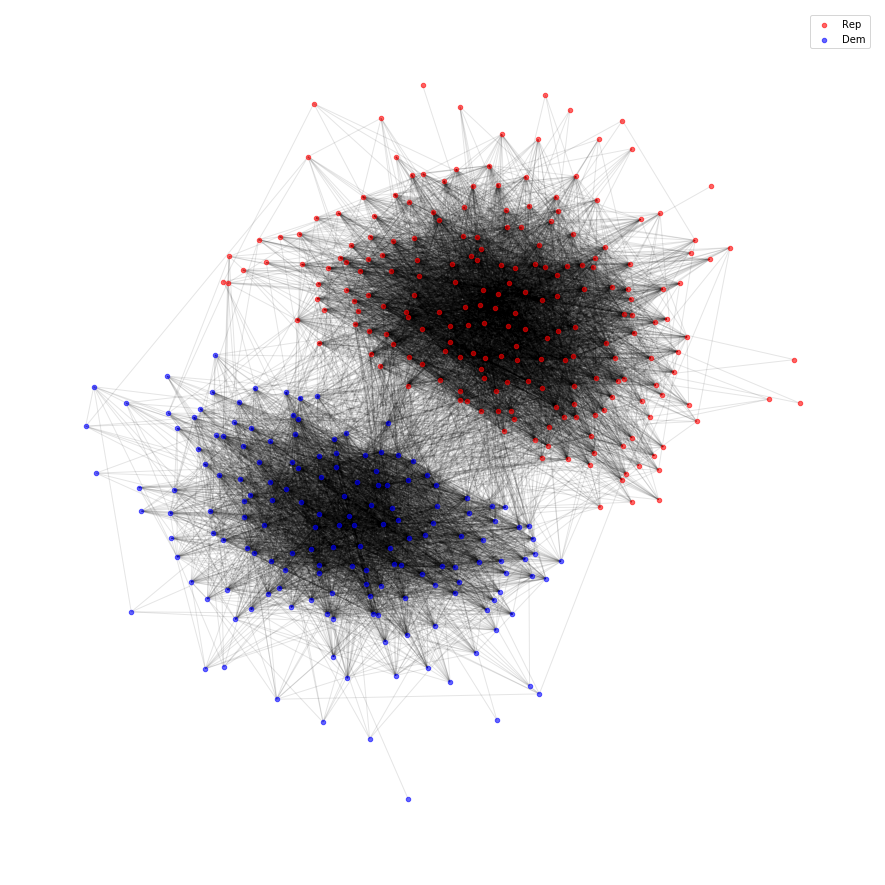

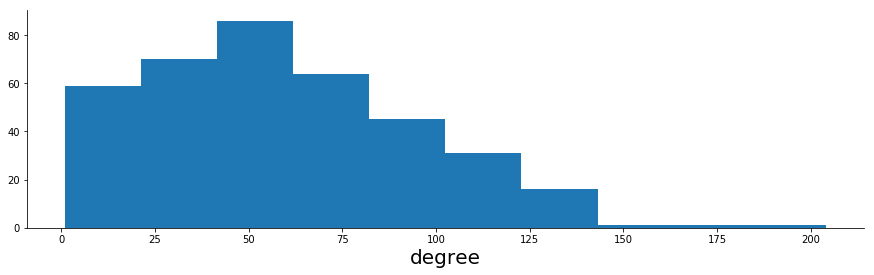

0.5101267001217928
374
11105


In [228]:
plt.axes([2,3,2,3])

#nx.draw(G, with_labels=True, font_weight='bold', alpha=0.6, pos = graphviz_layout(G))

pos = graphviz_layout(G)
#pos = nx.spring_layout(G)

nx.draw_networkx_edges(G, node_size=12, alpha = 0.1, pos=pos)

nx.draw_networkx_nodes(G, font_size=8, nodelist=R_nodes , node_size=20, node_color="red", alpha = 0.6, pos=pos, label = "Rep")
nx.draw_networkx_nodes(G, font_size=8, nodelist=D_nodes , node_size=20, node_color="blue", alpha = 0.6, pos=pos, label = "Dem")
#nx.draw_networkx_nodes(G, font_size=8, nodelist=N_nodes , node_size=20, node_color="cyan", alpha = 0.6, pos=graphviz_layout(G), label = "Indie") 

plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True, bottom=True)

plt.savefig('net264.pdf', bbox_inches="tight")
plt.show()

#----------------------------------------------------

plt.figure(figsize=[15,4])

plt.hist(list(dict(G.degree()).values()))#, bins=np.arange(0,10,1), density=True, alpha = 0.6)

#sns.kdeplot(list(dict(G.degree()).values()), label = "kde (bw = 0.4)", bw=0.4, color="darkorange")
#G_norm = stats.norm(np.mean(list(dict(G.degree()).values())),np.std(list(dict(G.degree()).values())))
#grid = np.arange(0,30,0.1)
#plt.plot(grid,G_norm.pdf(grid), color = "darkblue", label = "normal distribution")

#plt.xlim(1,10)
plt.xlabel("degree", fontsize = 20)
sns.despine()

plt.show()

nx.write_gexf(G, "small_set.gexf", version="1.2draft")

print(nx.average_clustering(G)) # tolkning, tak.
print(len(G.nodes()))
print(len(G.edges()))

In [229]:
# nu som meta/atrributes, hvis det skal bruges... Størrelse på nodes?
bb = nx.betweenness_centrality(G)
dg = dict(nx.degree(G))
dgc = nx.degree_centrality(G)

nx.set_node_attributes(G, dg, "degree")
nx.set_node_attributes(G, dgc, "degree_cent")
nx.set_node_attributes(G, bb, "betweenness_cent")

# Making the net_stats set:
(hver mange er der af hver?)

----

# Degree centrality

$$
\frac{\text{number of nieghbours a node has}}{\text{number of nieghbours a nodes could possibly have}}
$$

If there is no self-loops then the max number of nieghbours a node can have is $all\_nodes - self$
captures highly conncted nodes.


# Betweenness centrality

$$
\frac{\text{num. shortets paths through node}}{\text{all possible shortest paths}}
$$

Captures bottlesneck-nodes rather then highly connnected nodes.

Used to find individuels wich bridge two communites, e.g. conservatives and liberals

Kan gøre gøre noget med udviklinge her? Hvor meget entropy der er? Eller noget..

In [230]:
communities = community.best_partition(G) # det gør du igen senere...

DG = pd.DataFrame(pd.Series(dict(nx.degree(G)))).reset_index().rename(columns={'index': 'rep', 0: 'degree'})
DC = pd.DataFrame(pd.Series(nx.degree_centrality(G))).reset_index().rename(columns={'index': 'rep', 0: 'degree_cent'})
BC = pd.DataFrame(pd.Series(nx.betweenness_centrality(G))).reset_index().rename(columns={'index': 'rep', 0: 'betweenness_cent'})
COM = pd.DataFrame(pd.Series(communities)).reset_index().rename(columns={'index': 'rep', 0: 'Louvian_communities'})


net_stats = BC.merge(DC)
net_stats = net_stats.merge(DG)
net_stats = net_stats.merge(COM)


sub_house = df_house[["party","twitter_account"]]
sub_house.columns = ["party", "rep"]

net_stats = net_stats.merge(sub_house)

net_stats.sample(6)


,rep,betweenness_cent,degree_cent,degree,Louvian_communities,party
131,RepDianeBlack,0.012162,0.428954,160,0,R
268,RepPittenger,0.002061,0.166220,62,0,R
82,RepBobGibbs,0.005858,0.372654,139,0,R
185,RepJimmyPanetta,0.000383,0.072386,27,1,D
325,RepTomGarrett,0.001303,0.112601,42,0,R
241,RepMattGaetz,0.000878,0.117962,44,0,R


In [231]:
net_stats.describe() 

,betweenness_cent,degree_cent,degree,Louvian_communities
count,374.000000,374.000000,374.000000,374.000000
mean,0.002696,0.159209,59.385027,0.433155
std,0.004738,0.096691,36.065570,0.496175
min,0.000000,0.002681,1.000000,0.000000
25%,0.000336,0.088472,33.000000,0.000000
50%,0.001179,0.148794,55.500000,0.000000
75%,0.003374,0.222520,83.000000,1.000000
max,0.058960,0.546917,204.000000,1.000000


In [232]:
net_stats.pivot_table(values=["betweenness_cent", "degree_cent", "degree", "Louvian_communities"], index="party", margins=True)


,Louvian_communities,betweenness_cent,degree,degree_cent
party,,,,
D,1.000000,0.002901,58.666667,0.157283
R,0.000000,0.002539,59.933962,0.160681
All,0.433155,0.002696,59.385027,0.159209


See the Louvian_communities are pefectly split between parties. This is plotted later again.

In [233]:
net_stats.pivot_table(values=["degree"], index="party", aggfunc=sum, margins=True) # så det er edges * 2!

,degree
party,
D,9504
R,12706
All,22210


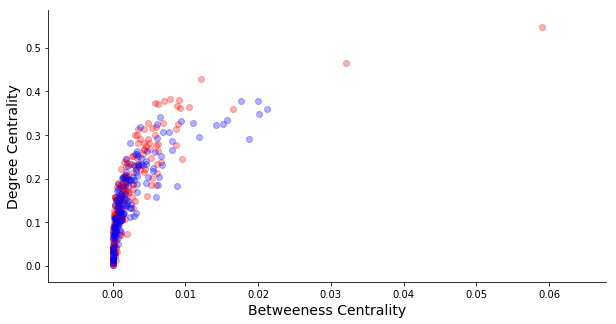

In [234]:
RL = net_stats[net_stats.party == "R"]
DL = net_stats[net_stats.party == "D"]

party_list = [RL,DL]


plt.figure(figsize = [10,5])


my_colors = ["red","blue","cyan"]

for i in range(len(party_list)):
    plt.scatter(party_list[i].betweenness_cent, party_list[i].degree_cent, alpha = 0.3, color = my_colors[i])


plt.xlabel("Betweeness Centrality", fontsize = 14)
plt.ylabel("Degree Centrality", fontsize = 14)

sns.despine()
plt.show()

# Cliques

In [235]:
CL = pd.DataFrame(pd.Series(nx.find_cliques(G))).rename(columns={ 0: 'clique'}) # split in dems and reps!
CL["clique_size"] = [len(n) for n in CL["clique"]]

CL.sort_values("clique_size", ascending=False).head(6)

,clique,clique_size
96257,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23
96255,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23
103208,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23
103207,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23
99366,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23
99365,"[GOPLeader, RepDianeBlack, DarrellIssa, Marsha...",23


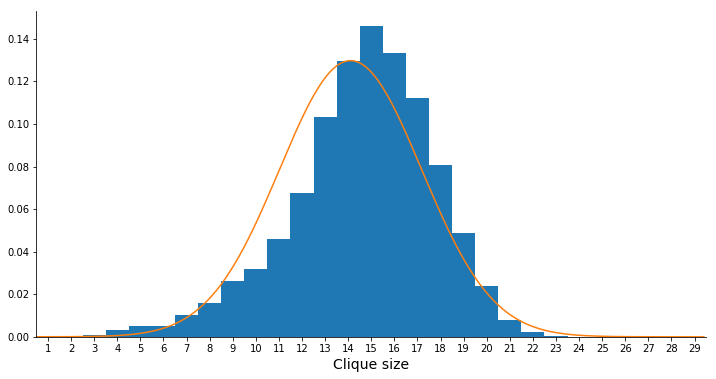

In [257]:
plt.figure(figsize=[12,6])
plt.hist(CL.clique_size, bins=np.arange(1,30,1), density=True)


CL_norm = stats.norm(np.mean(CL.clique_size),np.std(CL.clique_size))
grid = np.arange(0,30,0.1)
plt.plot(grid,CL_norm.pdf(grid), label = "normal distribution")


plt.xticks(np.arange(1.5,30.5,1), np.arange(1,30,1))# forskudt

plt.xlim(1,30)
plt.xlabel("Clique size", fontsize = 14)
sns.despine()
plt.show()

# Jaccard, periferi and Ademic/Adar (for somthing...)

The **Jaccard** coeficient - in a network setting - mearsurement for the numbers of common neighbors between to nodes. That is, to what extent does $node_1$'s set of nieghors overlab with $node_2$'s set of nieghbors:

$$
\text{score}(node_1,node_2) :=
\frac
{|\Gamma(node_1)\cap\Gamma(node_2)|}
{|\Gamma(node_1)\cup\Gamma(node_2)|}
$$

(rigth?)

In [237]:
# Jaccard:
jaccard = list(nx.algorithms.link_prediction.jaccard_coefficient(G))
jaccard_df = pd.DataFrame(jaccard)
# pd.Series(jaccard).isna().any()

jaccard_mat_df = jaccard_df.pivot_table(index=0, columns = 1, fill_value= 0) # fill alright?
jaccard_mat_df.columns = jaccard_mat_df.columns.droplevel()
jaccard_mat_df.sample(6)

1,AustinScottGA08,BennieGThompson,BettyMcCollum04,BillPascrell,BlumenauerMedia,BobbyScott,BradSherman,Call_Me_Dutch,Clyburn,ConawayTX11,...,USRepKeating,USRepLong,USRepMikeDoyle,USRepRickNolan,USRepRodney,VernBuchanan,WarrenDavidson,WhipHoyer,repdavetrott,teammoulton
0,,,,,,,,,,,,,,,,,,,,,
RepMimiWalters,0.383562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0,0.000000,...,0.000000,0.000000,0.00000,0.031579,0.0,0.140000,0.079365,0.010417,0.000000,0.012821
RepPittenger,0.410256,0.021978,0.056000,0.000000,0.000000,0.108527,0.043860,0.107843,0.0,0.000000,...,0.000000,0.000000,0.00000,0.103093,0.0,0.182692,0.069444,0.051813,0.287671,0.073171
RepMcNerney,0.022989,0.263158,0.219780,0.045455,0.045455,0.326087,0.441176,0.226667,0.0,0.000000,...,0.000000,0.012658,0.02439,0.365079,0.0,0.020000,0.000000,0.000000,0.000000,0.116667
RepDennyHeck,0.021583,0.201923,0.490909,0.020619,0.031250,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.054455,0.00000,0.000000,0.0,0.026490,0.009259,0.000000,0.016129,0.176471
RepMullin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.0,0.134146,0.000000,0.000000,0.000000,0.000000
RepMarcyKaptur,0.019802,0.000000,0.388889,0.034483,0.052632,0.000000,0.272727,0.177778,0.0,0.007194,...,0.050847,0.029586,0.00000,0.000000,0.0,0.026549,0.000000,0.000000,0.048193,0.140845


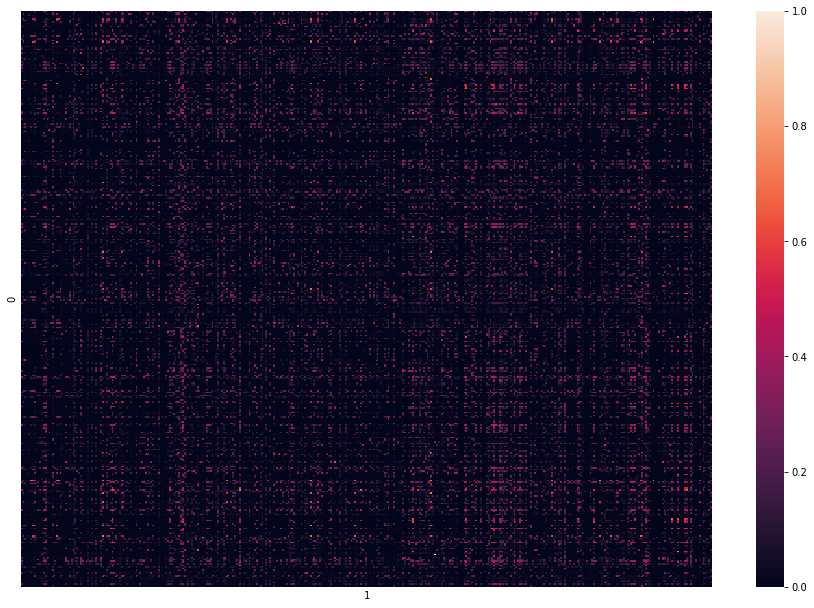

In [238]:
plt.axes([2,2,2,2])

sns.heatmap(jaccard_mat_df)

plt.xticks(())
plt.yticks(())
plt.show()

The **Ademic/Adar** coeficients is a somewhat related measure. It is defined as shuch:

$$
\sum_{\text{z : neighbors shared by }node_1,node_2}
\frac
{1}
{log(frequency(z))}
$$

The point is that this measurement gives a higer wieght to rarely shared neighbors, such that:

$$
\text{score}(node_1,node_2):=
\sum_{z\in\Gamma(node_1)\cap\Gamma(node_2)}
\frac
{1}
{log|\Gamma(z)|}
$$

In studie XXX YYY found that it out performed Jaccard coeficeint.

In [239]:
ademic = list(nx.algorithms.link_prediction.adamic_adar_index(G))
ademic_df = pd.DataFrame(ademic)

ademic_mat_df = ademic_df.pivot_table(index=0, columns = 1, fill_value= 0) # fill alright?
ademic_mat_df.columns = ademic_mat_df.columns.droplevel()
ademic_mat_df.sample(6)

1,AustinScottGA08,BennieGThompson,BettyMcCollum04,BillPascrell,BlumenauerMedia,BobbyScott,BradSherman,Call_Me_Dutch,Clyburn,ConawayTX11,...,USRepKeating,USRepLong,USRepMikeDoyle,USRepRickNolan,USRepRodney,VernBuchanan,WarrenDavidson,WhipHoyer,repdavetrott,teammoulton
0,,,,,,,,,,,,,,,,,,,,,
Raul_Labrador,0.000000,0.233075,0.889981,0.0,0.000000,1.975948,0.205443,0.00000,1.189908,0.000000,...,0.0,9.463318,0.000000,0.840762,0.0,9.004345,1.790885,1.377944,3.291041,0.233075
RepCicilline,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.202071,0.000000,9.000165,0.000000,2.595230
RepMikeCapuano,0.000000,0.223919,2.863109,0.0,0.236994,2.843589,2.097389,0.00000,0.000000,0.000000,...,0.0,0.671443,0.236994,1.380548,0.0,0.221687,0.000000,5.317894,0.000000,1.409818
RepLawrence,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,1.772432,0.000000,0.000000,0.000000,3.055042
RepAnnWagner,6.785372,0.855300,1.268349,0.0,0.000000,3.036316,0.852489,2.55433,1.742920,5.724094,...,0.0,0.000000,0.000000,2.406905,0.0,4.720944,0.000000,2.149061,3.936081,1.112021
RepCummings,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,1.061568,0.000000,0.000000,0.000000,3.970307


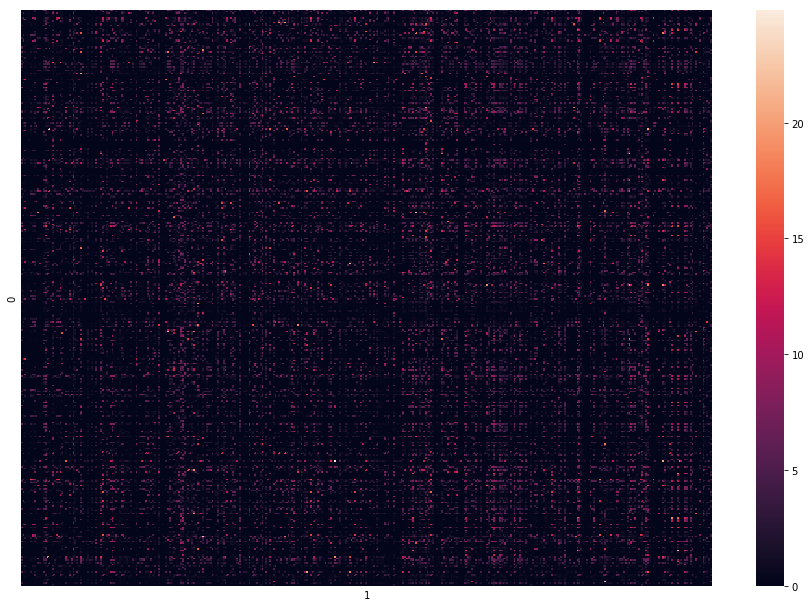

In [240]:
plt.axes([2,2,2,2])

sns.heatmap(ademic_mat_df)

plt.xticks(())
plt.yticks(())
plt.show()

In [241]:
# sort the matrices by party.

Average coef between R and D:
(some smart loop)

In [242]:
party_list_scores = []

for i in range(len(jaccard_df[0])):
    if jaccard_df[0][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")

jaccard_df["party_of_node"] =  party_list_scores
        
party_list_scores = []

for i in range(len(jaccard_df[0])):
    if jaccard_df[1][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")
        
jaccard_df["party_of_neighbor"] =  party_list_scores
jaccard_df.columns = {"node":0, "neighbor": 1, "jaccard_score" : 2, "party_of_node":"party_of_node", "party_of_neighbor":"party_of_neighbor"}



In [243]:
print(jaccard_df[jaccard_df.party_of_node == "R"]["jaccard_score"].mean())
print(jaccard_df[jaccard_df.party_of_node == "D"]["jaccard_score"].mean())


0.08581464331285459
0.07983848252452645


In [244]:
party_list_scores = []

for i in range(len(ademic_df[0])):
    if ademic_df[0][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")

ademic_df["party_of_node"] =  party_list_scores
        
party_list_scores = []

for i in range(len(ademic_df[0])):
    if ademic_df[1][i] in repulicans:
        party_list_scores.append("R")
    else:
        party_list_scores.append("D")
        
ademic_df["party_of_neighbor"] =  party_list_scores

ademic_df.columns = {"node":0, "neighbor": 1, "ademic_score" : 2, "party_of_node":"party_of_node", "party_of_neighbor":"party_of_neighbor"}


In [245]:
print(ademic_df[ademic_df.party_of_node == "R"]["ademic_score"].mean())
print(ademic_df[ademic_df.party_of_node == "D"]["ademic_score"].mean())


1.9115320000397273
1.752241769852136


# Cores:

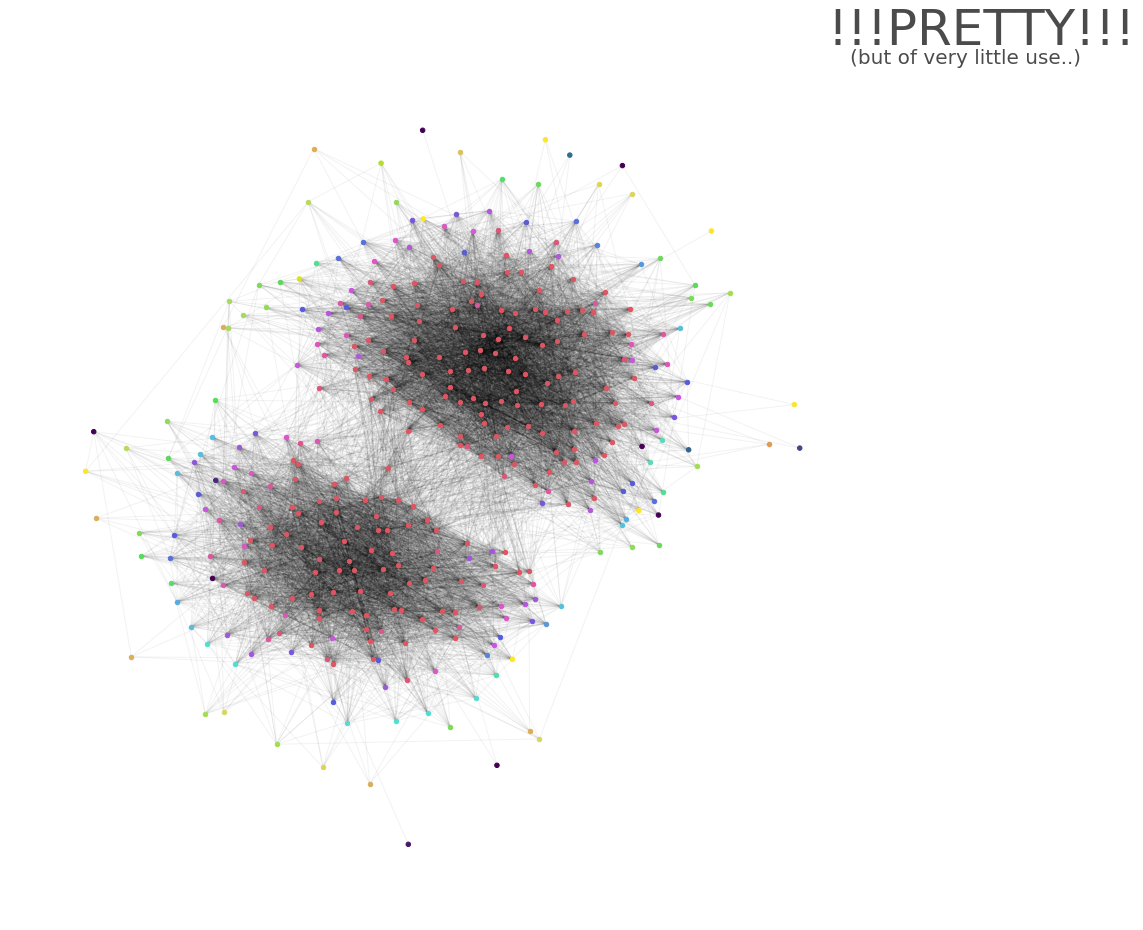

In [246]:
# https://networkx.github.io/documentation/latest/reference/algorithms/core.html
cores = nx.algorithms.core.core_number(G)

plt.axes([2,3,2,3])

size = float(len(set(cores.values())))
pos=graphviz_layout(G)

n_cores = len(pd.Series(nx.algorithms.core.core_number(G)).unique())
my_colors = sns.color_palette("hls", n_cores)

count = 0
for com in set(cores.values()) :
    
    list_nodes = [nodes for nodes in cores.keys() if cores[nodes] == com]
    
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
    
    count += 1

plt.text(180, 210, "!!!PRETTY!!!", fontsize = 50, alpha = 0.7)
plt.text(190, 200, "(but of very little use..)", fontsize = 20, alpha = 0.7)


nx.draw_networkx_edges(G,pos, alpha=0.05)

#plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.show()

# Modularity:

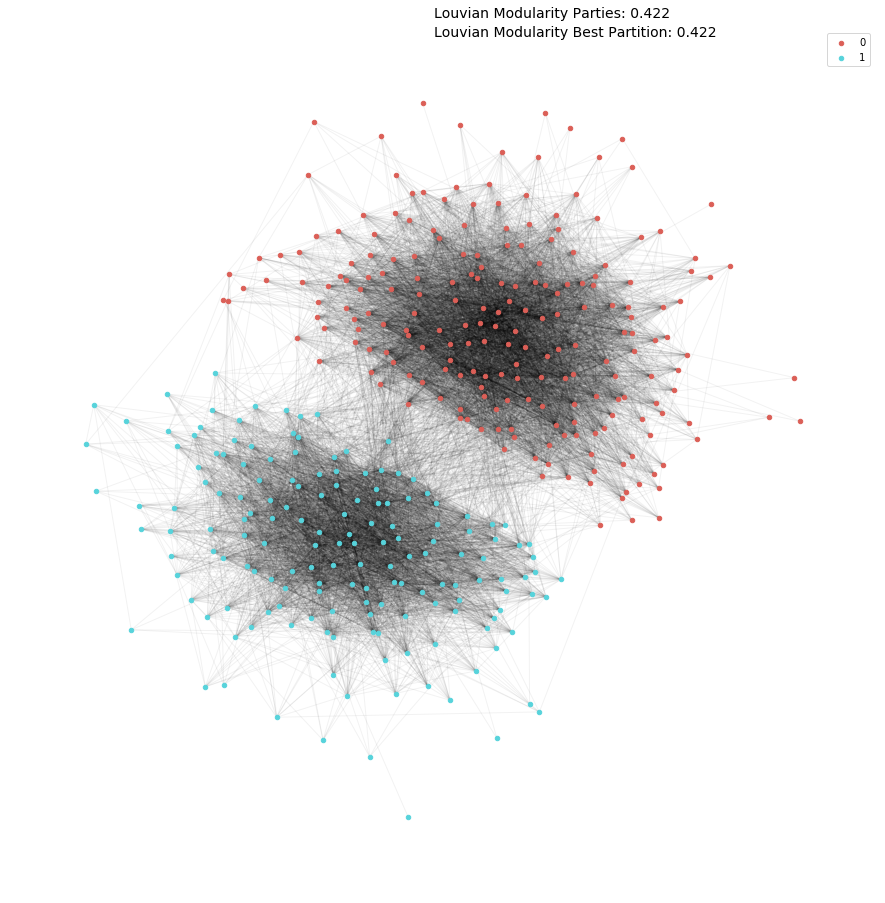

In [247]:
plt.axes([2,3,2,3])

parties = dict(G.nodes(data="party_int"))
communities = community.best_partition(G)
modularity_best_pat = community.modularity(communities, G) 
modularity_parties = community.modularity(parties, G) # virker først når du har ordnet det med små og store bogstaver...

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(G)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

plt.text(0, 200, "Louvian Modularity Best Partition: " + str(round(modularity_best_pat,3)), fontsize = 14)
plt.text(0, 210, "Louvian Modularity Parties: " + str(round(modularity_parties,3)), fontsize = 14) # virker først når du har ordnet det med små og store bogstaver...

nx.draw_networkx_edges(G,pos, alpha=0.05)

plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.show()

In [248]:
# remove nons and outliers:
GV = G.copy()

non = []

for node in GV.nodes(data="voting_with_party_pct"):
    if node[1] == None:
        non.append(node[0])

GV.remove_nodes_from(non)

low_score = []

for node in GV.nodes(data="voting_with_party_pct"):
    if node[1] < 67:
        low_score.append(node[0])

GV.remove_nodes_from(low_score)

In [249]:
G = nx.Graph()
G.add_edges_from(edges) # Indies må komme herfra! Der må være edges som du ikke har nodes på....
G.add_nodes_from(repulicans, party = "R", party_int = 0)
G.add_nodes_from(democrats, party = "D", party_int = 1)

no_party = []

for i, p in list(G.nodes(data=True)):
    if len(p) == 0:
        no_party.append(i)
        
G.remove_nodes_from(no_party) # det er nok det her der burde ske.. men så skal low_degree ind efter...

#G.add_nodes_from(no_party, party = "non", party_int = 2)


low_degree = []

for i in list(G.degree()):
    if i[1] < 1: # a bit high..
        low_degree.append(i[0])
        
G.remove_nodes_from(low_degree)


R_nodes = [n for n, p in list(G.nodes(data=True)) if p['party'] == 'R']
D_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'D']
#N_nodes =  [n for n, p in list(G.nodes(data=True)) if p['party'] == 'non']

# kunne også være et andet ste, men nu er du jo igang her..
voting_with_party = dict(df_house[["twitter_account","votes_with_party_pct"]].dropna().to_dict(orient='split')["data"])
nx.set_node_attributes(G, voting_with_party, "voting_with_party_pct")

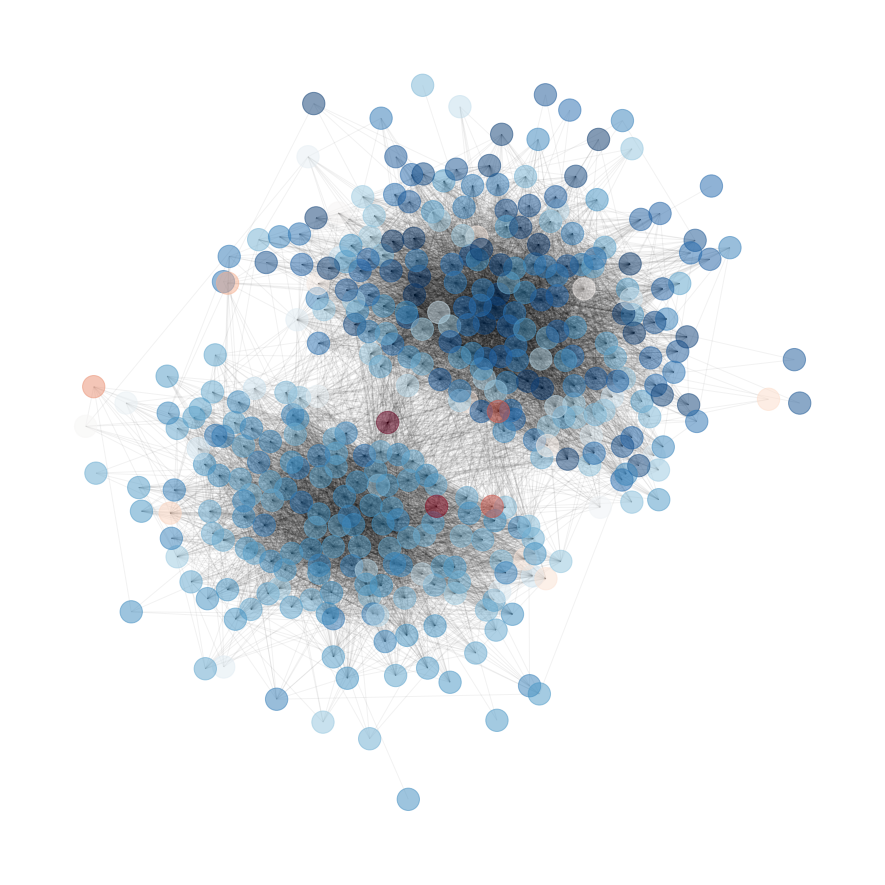

In [250]:
plt.axes([2,3,2,3])

val_map = dict(GV.nodes(data = "voting_with_party_pct"))

values = [val_map.get(node) for node in GV.nodes()]
n_val = len(set(values))
#nx.draw(G, cmap = plt.get_cmap('Blues'), node_color=values, pos = pos, node_size=20)
nx.draw_networkx_nodes(GV, cmap = plt.get_cmap('RdBu', n_val), node_color=values, pos = pos, node_size=500, alpha= 0.5)
nx.draw_networkx_edges(GV,pos, alpha=0.05)

plt.xticks(())
plt.yticks(())

sns.despine(left=True, bottom=True)
plt.show()

**So here we see the modularity captures the two parties perfectly**

# Breath first search:
# but why?

In [251]:
def path_exists(G, node1, node2):
    """
    This function checks whether a path exists between two nodes (node1, node2) in graph G.
    """
    visited_nodes = set()
    queue = [node1]
    
    for node in queue:  
        neighbors = G.neighbors(node)
        if node2 in neighbors:
            print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
            break

        else:
            visited_nodes.add(node)
            queue.extend([n for n in neighbors if n not in visited_nodes])
        
        # Check to see if the final element of the queue has been reached
        if node == queue[-1]:
            print('Path does not exist between nodes {0} and {1}'.format(node1, node2))

            # Place the appropriate return statement
            return False

# Spilliting the two sets

In [252]:
GR = G.subgraph(R_nodes)
GD = G.subgraph(D_nodes)

In [253]:
# Her var det du skulle bruge...
print(len(list(GR.nodes())))
print(len(list(GD.nodes())))

212
162


# R only

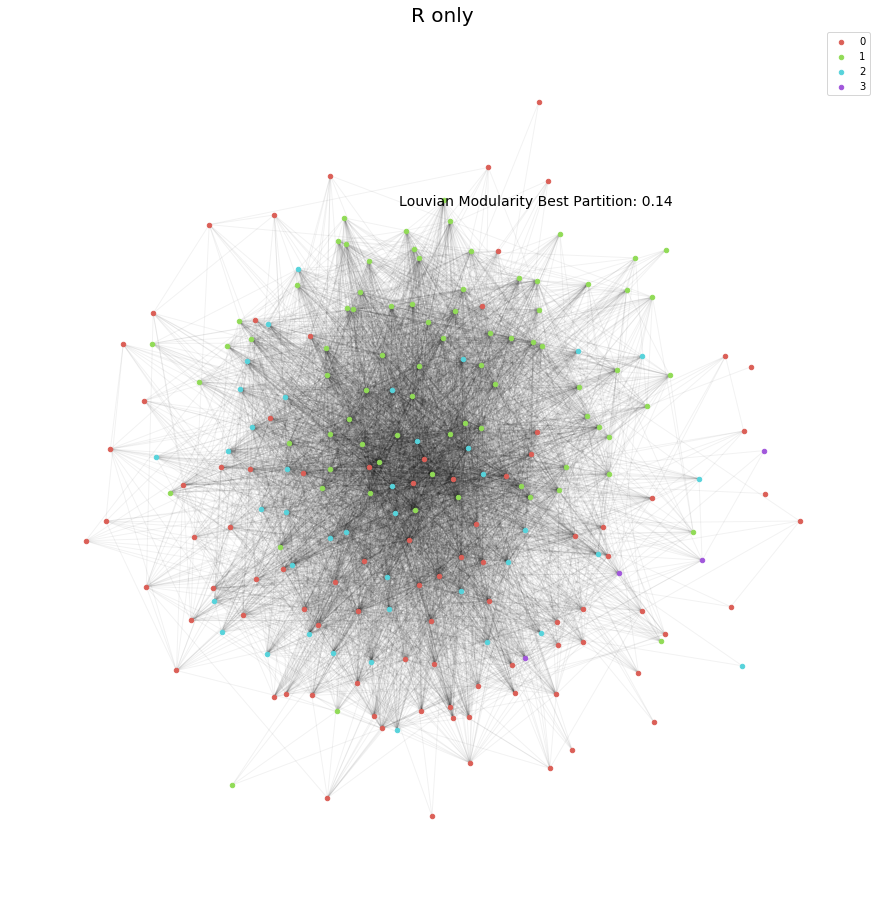

In [254]:
plt.axes([2,3,2,3])

communities = community.best_partition(GR)
modularity_best_pat = community.modularity(communities, GR) 

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(GR)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(GR, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

plt.text(-10, 100, "Louvian Modularity Best Partition: " + str(round(modularity_best_pat,3)), fontsize = 14)

nx.draw_networkx_edges(GR,pos, alpha=0.05)

plt.title("R only", fontsize = 20)
plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.show()

# D only

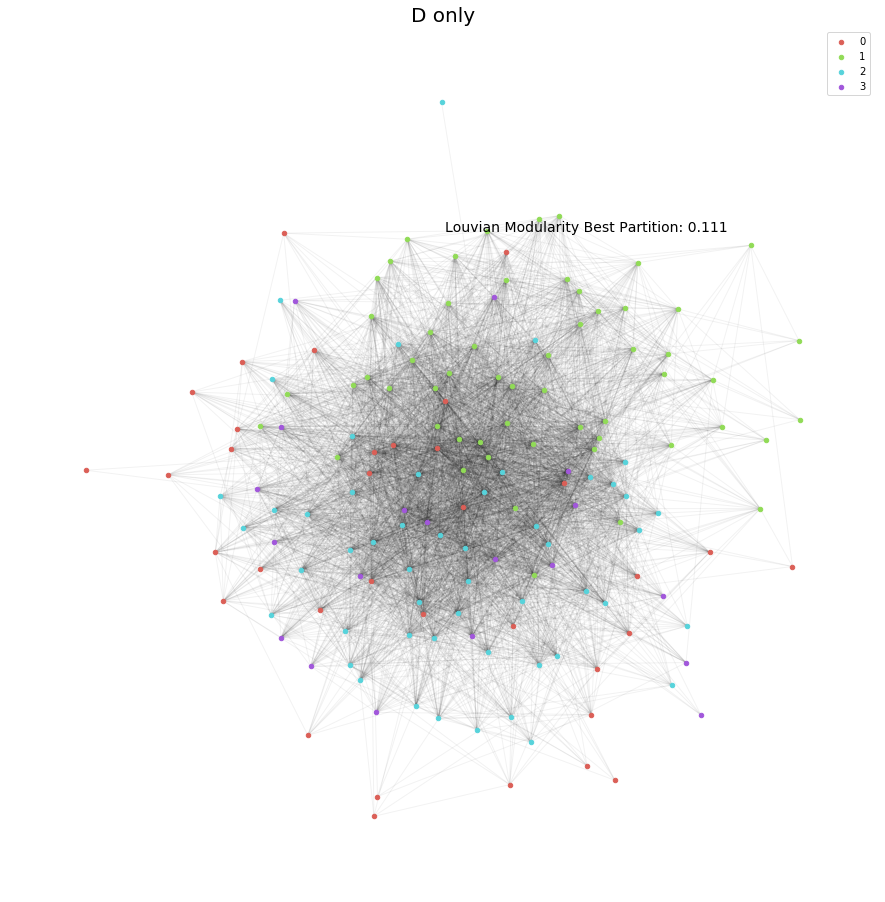

In [255]:
plt.axes([2,3,2,3])

communities = community.best_partition(GD)
modularity_best_pat = community.modularity(communities, GD) 

n_communities = len(set(list(communities.values())))
my_colors = sns.color_palette("hls", n_communities)
count = 0

pos=graphviz_layout(GD)

for com in set(communities.values()):
        list_nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
        
        nx.draw_networkx_nodes(GD, pos, list_nodes, node_size = 20, node_color = my_colors[count], label = str(com))
        
        count += 1

plt.text(-10, 100, "Louvian Modularity Best Partition: " + str(round(modularity_best_pat,3)), fontsize = 14)

nx.draw_networkx_edges(GD,pos, alpha=0.05)

plt.title("D only", fontsize = 20)
plt.legend()
plt.xticks(())
plt.yticks(())
sns.despine(left=True,bottom=True)
plt.show()

important caucuses:

The freedom caucus - 40 ish members. Typical more (conservative)[http://www.pewresearch.org/fact-tank/2015/10/20/house-freedom-caucus-what-is-it-and-whos-in-it/] then other R's.


The Black caucus

In [256]:
url = "http://www.pewresearch.org/fact-tank/2015/10/20/house-freedom-caucus-what-is-it-and-whos-in-it/"
r = requests.get(url) #, auth=('user', 'pass'))

soup = BeautifulSoup(r.text, 'lxml')
table = soup.find_all('table')[0]

freedom_caucus = []

row_marker = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        if "," in column.get_text():
            freedom_caucus.append(column.get_text())
            column_marker += 1
            
freedom_caucus

['Amash, Justin',
 'Blum, Rod',
 'Brat, David',
 'Bridenstine, Jim',
 'Brooks, Mo',
 'Buck, Ken',
 'Clawson, Curt',
 'Desantis, Ron',
 'DesJarlais, Scott',
 'Duncan, Jeff',
 'Fleming, John',
 'Franks, Trent',
 'Garrett, Scott',
 'Gosar, Paul',
 'Griffith, Morgan',
 'Harris, Andy',
 'Hice, Jody',
 'Huelskamp, Tim',
 'Jordan, Jim (chairman)',
 'Labrador, Raúl',
 'Loudermilk, Barry',
 'Lummis, Cynthia',
 'Meadows, Mark',
 'Mooney, Alex',
 'Mulvaney, Mick',
 'Palmer, Gary',
 'Pearce, Stevan',
 'Perry, Scott',
 'Posey, Bill',
 'Rothfus, Keith',
 'Salmon, Matthew',
 'Sanford, Mark',
 'Schweikert, David',
 'Stutzman, Marlin',
 'Weber, Randy',
 'Yoho, Ted']